In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.sparse as sparse #for numpy.array - pd.dataframe column conversion
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import os, sys, math, json
import warnings
warnings.filterwarnings('ignore')

2024-07-09 14:26:01.693563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preparing the dataframe
### Reading the input files

In [2]:
debug = True
nrows_ = None
if debug : nrows_ = 1000

df_gjet = pd.concat([
    pd.read_csv('FlattenedCSVFiles/df_GJet_PT-10to40.csv', nrows=nrows_),
    pd.read_csv('FlattenedCSVFiles/df_GJet_PT-40.csv', nrows=nrows_)
])
df_gjet['sample'] = 'gjet'
df_gjet = df_gjet.reset_index(drop=True)

df_qcd = pd.concat([
    pd.read_csv('FlattenedCSVFiles/df_QCD_PT-80to120.csv',     nrows=nrows_),
    pd.read_csv('FlattenedCSVFiles/df_QCD_PT-120to170.csv',    nrows=nrows_),  
    pd.read_csv('FlattenedCSVFiles/df_QCD_PT-170to300.csv',    nrows=nrows_),  
    pd.read_csv('FlattenedCSVFiles/df_QCD_PT-300toInf.csv',    nrows=nrows_),  
])
df_qcd['sample']= 'qcd'
df_qcd = df_qcd.reset_index(drop=True)

df_taugun = pd.concat([
    pd.read_csv('FlattenedCSVFiles/df_TauGun_E-10to100.csv',   nrows=nrows_),  
    pd.read_csv('FlattenedCSVFiles/df_TauGun_E-100to3000.csv', nrows=nrows_),
])
df_taugun['sample'] = 'taugun'
df_taugun = df_taugun.reset_index(drop=True)

print('Files read.')

Files read.


### Defining signal and background

In [3]:
def filter_signal(df):
    # Note: When a candidate matches with a gen-particle, it's genpt is NOT -999
    signal_flag = (~(df['phoMatchingGenPt'] < 0)) & (df['isPromptFinalState'] == 1)
    filtered_df = df[signal_flag]
    return filtered_df

def filter_background(df):
    background_flag1 = (df['phoMatchingGenPt'] < 0) # In case of fakes
    background_flag2 = (~(df['phoMatchingGenPt'] < 0)) & (df['isPromptFinalState'] == 0) # Matches with gen, but non-prompt
    filtered_df = df[background_flag1 | background_flag2]
    return filtered_df
    
df_sig = filter_signal(df_gjet)
df_sig['truth'] = 1 #Target is what the NN tries to predict
df_sig = df_sig.reset_index(drop=True)

df_bkg = pd.concat([filter_background(df_qcd), filter_background(df_taugun)])
df_bkg['truth'] = 0
df_bkg = df_bkg.reset_index(drop=True)

data = pd.concat([df_sig, df_bkg])
data = data[data['phoPt']>10] #Offline Pt cut
data = data.sample(frac=1).reset_index(drop=True) #Randomizing the rows

In [4]:
data[['phoPt','phoEta','phoPhi','phoMatchingGenPt','isPromptFinalState','isPFPhoton','sample','truth']]

,phoPt,phoEta,phoPhi,phoMatchingGenPt,isPromptFinalState,isPFPhoton,sample,truth
0,61.596901,0.358247,-2.988970,24.342873,0,0,qcd,0
1,35.621105,2.368477,2.493335,11.751356,0,0,qcd,0
2,42.210339,-0.157282,-1.853677,34.308041,0,0,taugun,0
3,288.784729,1.917709,-1.698539,-999.000000,-999,1,taugun,0
4,21.459749,-1.212264,-2.694908,17.618969,1,1,gjet,1
...,...,...,...,...,...,...,...,...
6842,457.006165,0.852572,-1.353964,-999.000000,-999,1,taugun,0
6843,99.378418,2.414028,2.703038,47.637794,0,1,qcd,0
6844,140.338135,-1.995379,2.912217,24.304729,0,0,qcd,0
6845,14.295885,1.751784,3.020919,15.778908,0,1,taugun,0


### Filtering against barrel, endcap, or forward region
- For barrel, `abs(eta) < 1.442`
- For endcap, `abs(eta) > 1.566`
- For foward region, `abs(eta) > 2.4`

In [5]:
data = data[abs(data['phoEta']) < 1.442]
data = data.reset_index(drop=True)
print('Dataframe is ready for evaluation.')

nsig = len(data.query('(truth==1)'))
nbkg = len(data.query('(truth==0)'))
nqcd = len(data.query('(sample=="qcd")'))
ntau = len(data.query('(sample=="taugun")'))
frac_qcd = (nqcd/nbkg)*100
frac_tau = (ntau/nbkg)*100

print('-'*40)
print('Statistics:')
print(f'nSig = {nsig} (all GJet)')
print(f'nBkg = {nbkg} ({frac_qcd:.1f}% QCD + {frac_tau:.1f}% TauGun)')
print('-'*40)

Dataframe is ready for evaluation.
----------------------------------------
Statistics:
nSig = 564 (all GJet)
nBkg = 3384 (61.9% QCD + 38.1% TauGun)
----------------------------------------


In [6]:
data.columns

Index(['phoE', 'phoEt', 'phoPt', 'phoEta', 'phoPhi', 'phoHoverE',
       'phoHoverECone', 'phoHoverEValid', 'phoSigmaIEtaIEtaFull5x5',
       'phoSigmaIEtaIPhiFull5x5', 'phoSigmaIPhiIPhiFull5x5', 'phoR9Full5x5',
       'phoR93x3', 'phoSigmaIEtaIEta3x3', 'phoEcalPFClusterIso',
       'phoHcalPFClusterIso', 'phoEcalRecHit', 'phoHcalTower',
       'phohasPixelSeed', 'phoTrkSumPtHollow', 'phoTrkSumPtSolid',
       'isPromptFinalState', 'isDirectHardProcessTauDecayProductFinalState',
       'isDirectHadronDecayProduct', 'isTauDecayProduct',
       'isPromptTauDecayProduct', 'isDirectTauDecayProduct',
       'isDirectPromptTauDecayProduct',
       'isDirectPromptTauDecayProductFinalState', 'isHardProcess',
       'fromHardProcessFinalState', 'fromHardProcessDecayed',
       'phoMatchingGenPt', 'isPionMother', 'isPFPhoton', 'sample', 'truth'],
      dtype='object')

## Loading the model and the training variables

In [7]:
train_var = [
    ("phoHoverE", 0, 1),
    ("phoTrkSumPtHollow", 0, 1),
    ("phoEcalRecHit", 0, 1),
    ("phoSigmaIEtaIEta3x3", 0, 1),
    ("phoSigmaIEtaIEtaFull5x5", 0, 1),
    ("phoSigmaIEtaIPhiFull5x5", 0, 1),
    ("phoEcalPFClusterIso", 0, 1),
    ("phoHcalPFClusterIso", 0, 1),
    ("phohasPixelSeed", 0, 1),
    ("phoR9Full5x5", 0, 1),
    ("phoHcalTower", 0, 1),
]

jsonfile = 'model_info.json'
with open(jsonfile,'r') as infile: modeldata = json.load(infile)

def load_model(modelname):
    for model, norm in modeldata.items():
        if model == modelname:
            print(f'loading model: {modelname} ... ')
            mymodel = tf.keras.models.load_model(f'TrainedModels/{modelname}/{modelname}.h5')
            mymodel.load_weights(f'TrainedModels/{modelname}/{modelname}.h5')
            
            for i, (var_name, _, _) in enumerate(train_var):
                if var_name in norm:
                    train_var[i] = (var_name, norm[var_name]['min'], norm[var_name]['max'])
            
            return mymodel
    
model = load_model('var11_barrel')
print('The model is loaded. The following normalizations will be used in the min-max scaler.')
print('Variable'.ljust(29), 'min'.ljust(17), 'max')
for var, min_val, max_val in train_var:
    print(f'{var.ljust(30)}{str(min_val).ljust(18)}{str(max_val)}')

loading model: var11_barrel ... 


2024-07-09 14:26:04.953444: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The model is loaded. The following normalizations will be used in the min-max scaler.
Variable                      min               max
phoHoverE                     0                 1
phoTrkSumPtHollow             0                 1
phoEcalRecHit                 0                 1
phoSigmaIEtaIEta3x3           0.0               0.024192091
phoSigmaIEtaIEtaFull5x5       4.734276e-05      0.030323075
phoSigmaIEtaIPhiFull5x5       -0.0005914965     0.0005338515
phoEcalPFClusterIso           0.0               1512.3279
phoHcalPFClusterIso           0.0               1771.452
phohasPixelSeed               0                 1
phoR9Full5x5                  0.14421068        28.155016
phoHcalTower                  0                 1


### Preparing normalized X (input parameters) and truth (target) arrays

In [9]:
train_cols = [entry[0] for entry in train_var]

X, y = data[train_cols].values, data[['truth']].values

# Extract min and max values into NumPy arrays
min_values = np.array([entry[1] for entry in train_var])
max_values = np.array([entry[2] for entry in train_var])

def min_max_scaler(X, min_values, max_values):
    MaxMinusMin = max_values - min_values
    normedX = 2 * ((X - min_values) / MaxMinusMin) - 1.0
    return normedX

X = min_max_scaler(X, min_values, max_values)

print('The input parameters are ready. They have the following shapes.')
print(X.shape, y.shape)

The input parameters are ready. They have the following shapes.
(3948, 11) (3948, 1)


### Evaulating the model and looking at the cut-based ID

In [10]:
def get_score_and_roc(model, X, y):
    #Predict using the existing model:
    y_truth = y
    y_predicted = model.predict(X)
    
    fpr, tpr, _ = roc_curve(y_truth, y_predicted) 
    auc_score = auc(tpr,1-fpr)    
    tpr=tpr*100
    fnr=(1-fpr)*100
    
    return y_predicted, fnr, tpr, auc_score

nnscore, fnr, tpr, auc_score = get_score_and_roc(model, X, y)
print('The model is evulated, and TPR, FNR are calculated.')

data["NNScore"] = nnscore
print('The dataframe is updated with the NNscore.')

124/124 [==============================] - 0s 2ms/step
The model is evulated, and TPR, FNR are calculated.
The dataframe is updated with the NNscore.


In [12]:
data[['phoPt','phoEta','phoPhi','phoMatchingGenPt','isPromptFinalState','isPFPhoton','sample','truth','NNScore']]

,phoPt,phoEta,phoPhi,phoMatchingGenPt,isPromptFinalState,isPFPhoton,sample,truth,NNScore
0,61.596901,0.358247,-2.988970,24.342873,0,0,qcd,0,0.000000e+00
1,42.210339,-0.157282,-1.853677,34.308041,0,0,taugun,0,0.000000e+00
2,21.459749,-1.212264,-2.694908,17.618969,1,1,gjet,1,0.000000e+00
3,51.829189,-0.451352,0.276568,51.139862,1,1,gjet,1,0.000000e+00
4,214.566147,-0.813854,1.039491,16.990494,0,0,qcd,0,0.000000e+00
...,...,...,...,...,...,...,...,...,...
3943,26.420801,-0.465884,0.315264,-999.000000,-999,0,taugun,0,4.257971e-35
3944,19.881634,-1.328196,-2.715698,-999.000000,-999,0,taugun,0,0.000000e+00
3945,81.423752,-0.599094,-2.369269,32.195938,0,0,qcd,0,0.000000e+00
3946,457.006165,0.852572,-1.353964,-999.000000,-999,1,taugun,0,0.000000e+00


In [13]:
# The cut-based PF-ID :
print('Information on the cut-based ID :')
backgroundpass=len(data.query('(isPFPhoton == 1) & (truth == 0)'))
backgroundrej =len(data.query('(isPFPhoton == 0) & (truth == 0)'))
signalpass    =len(data.query('(isPFPhoton == 1) & (truth == 1)'))
signalrej     =len(data.query('(isPFPhoton == 0) & (truth == 1)'))
PF_bkgrej     =( backgroundrej/(backgroundpass+backgroundrej) )*100
PF_sigeff     =( signalpass/(signalpass+signalrej) )*100
print(f'Signal efficiency and background rejection of the cut-based ID : {PF_sigeff:.2f} % and {PF_bkgrej:.2f}%')

Information on the cut-based ID :
Signal efficiency and background rejection of the cut-based ID : 80.85 % and 80.35%


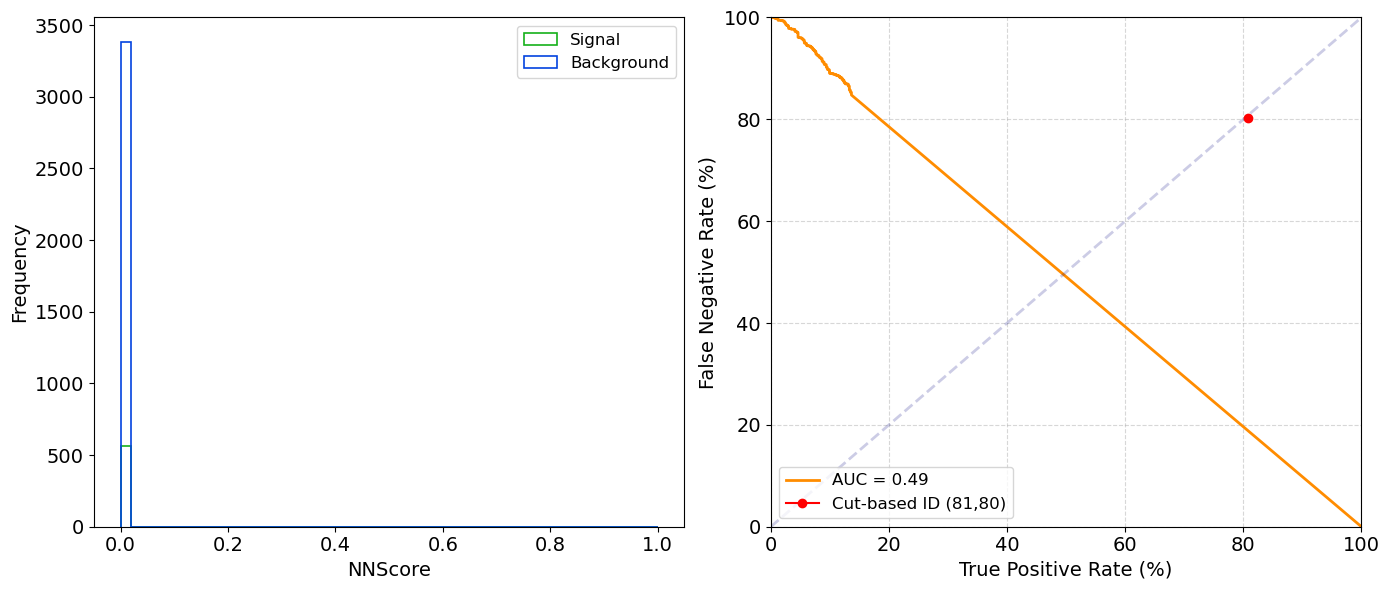

In [14]:
# Define custom binning for the NNScore
mybins = np.arange(0, 1.02, 0.02)

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Define common histogram properties
hist_props = {
    'histtype': 'step',
    'density': False,
    'linewidth': 1.2,
}

# Left subplot: NNScore distribution
axs[0].hist(data[data['truth']==1]['NNScore'], bins=mybins, color='xkcd:green', label='Signal', **hist_props)
axs[0].hist(data[data['truth']==0]['NNScore'], bins=mybins, color='xkcd:blue', label='Background', **hist_props)
axs[0].set_xlabel('NNScore', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].legend(fontsize=12)

# Right subplot: ROC curve (assuming you have tpr, fnr, auc_score, PF_sigeff, and PF_bkgrej defined)
axs[1].plot(tpr, fnr, color='darkorange', lw=2, label=f'AUC = {auc_score:.2f}')
axs[1].plot([0, 100], [0, 100], color='navy', lw=2, linestyle='--', alpha=0.2)
axs[1].plot(PF_sigeff, PF_bkgrej, marker='o', color="red", markersize=6, label=f'Cut-based ID ({PF_sigeff:.0f},{PF_bkgrej:.0f})')
axs[1].set_xlim([0.0, 100.0])
axs[1].set_ylim([0.0, 100.0])
axs[1].set_xlabel('True Positive Rate (%)', fontsize=14)
axs[1].set_ylabel('False Negative Rate (%)', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].grid(True, alpha=0.5, linestyle='--')
axs[1].legend(loc='lower left', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
